# DeepComedy: AI Generated Divine Comedy

Author: **Alessandro Pavesi, Federico Battistella**


This Notebook contains a **text generator RNN** that was trained on the **Divina Commedia** (the *Divine Comedy*) by **Dante Alighieri**. 

It's structure is extremely complex: the poem is composed by three Cantiche, each Cantica has 33 Terzine, each Terzina is composed by three verses, each verse is composed of 11 syllables, and its rhymes follow an **A-B-A-B-C-B-C** structure.

In [2]:
import time
import re

import numpy as np
import pandas as pd

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Attention, Flatten, Input
from tensorflow.keras.activations import elu, relu, softmax
from tensorflow.keras.metrics import categorical_accuracy, sparse_categorical_crossentropy, categorical_crossentropy

from matplotlib import pyplot as plt 

2.4.0


# Preliminaries Steps

## Import and initial cleaning

In [3]:
# Read the Divina Commedia
with open( "DivinaCommedia.txt", 'r', encoding="utf8") as file:
    divina_commedia = file.read()

# Replace rare characters
divina_commedia = divina_commedia.replace("ä", "a")
divina_commedia = divina_commedia.replace("é", "è")
divina_commedia = divina_commedia.replace("ë", "è")
divina_commedia = divina_commedia.replace("Ë", "E")
divina_commedia = divina_commedia.replace("ï", "i")
divina_commedia = divina_commedia.replace("Ï", "I")
divina_commedia = divina_commedia.replace("ó", "ò")
divina_commedia = divina_commedia.replace("ö", "o")
divina_commedia = divina_commedia.replace("ü", "u")

divina_commedia = divina_commedia.replace("(", "-")
divina_commedia = divina_commedia.replace(")", "-")

divina_commedia = re.sub(r'[0-9]+', '', divina_commedia)
divina_commedia = re.sub(r'\[.*\r?\n', '', divina_commedia)
divina_commedia = re.sub(r'.*Canto.*\r?\n', '', divina_commedia)

# divina_commedia = divina_commedia.replace(" \n", "\n")  # with this i lose the "terzina": results are not so exciting
#divina_commedia = divina_commedia.replace(" \n", "<eot>")  # end of terzina
#divina_commedia = divina_commedia.replace("\n", "<eor>")

In [4]:
print(divina_commedia[1:1000])

NFERNO



Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita. 

Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura! 

Tant'è amara che poco è più morte;
ma per trattar del ben ch'i' vi trovai,
dirò de l'altre cose ch'i' v' ho scorte. 

Io non so ben ridir com'i' v'intrai,
tant'era pien di sonno a quel punto
che la verace via abbandonai. 

Ma poi ch'i' fui al piè d'un colle giunto,
là dove terminava quella valle
che m'avea di paura il cor compunto, 

guardai in alto e vidi le sue spalle
vestite già de' raggi del pianeta
che mena dritto altrui per ogne calle. 

Allor fu la paura un poco queta,
che nel lago del cor m'era durata
la notte ch'i' passai con tanta pieta. 

E come quei che con lena affannata,
uscito fuor del pelago a la riva,
si volge a l'acqua perigliosa e guata, 

così l'animo mio, ch'ancor fuggiva,
si volse a retro a rimirar lo passo
che non lasciò già mai persona viva


In [5]:
# Check lenght of text
print(len(divina_commedia))

534049


## Vocabulary and Char2Idx

In [6]:
# Store unique characters into a dict with numerical encoding
unique_chars = list(set(divina_commedia))
unique_chars.sort()  # to make sure you get the same encoding at each run

# Store them in a dict, associated with a numerical index
char2idx = { char[1]: char[0] for char in enumerate(unique_chars) }


In [7]:
print(len(char2idx))

62


In [8]:
char2idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 "'": 4,
 ',': 5,
 '-': 6,
 '.': 7,
 ':': 8,
 ';': 9,
 '?': 10,
 'A': 11,
 'B': 12,
 'C': 13,
 'D': 14,
 'E': 15,
 'F': 16,
 'G': 17,
 'H': 18,
 'I': 19,
 'L': 20,
 'M': 21,
 'N': 22,
 'O': 23,
 'P': 24,
 'Q': 25,
 'R': 26,
 'S': 27,
 'T': 28,
 'U': 29,
 'V': 30,
 'Z': 31,
 'a': 32,
 'b': 33,
 'c': 34,
 'd': 35,
 'e': 36,
 'f': 37,
 'g': 38,
 'h': 39,
 'i': 40,
 'j': 41,
 'l': 42,
 'm': 43,
 'n': 44,
 'o': 45,
 'p': 46,
 'q': 47,
 'r': 48,
 's': 49,
 't': 50,
 'u': 51,
 'v': 52,
 'x': 53,
 'y': 54,
 'z': 55,
 'È': 56,
 'à': 57,
 'è': 58,
 'ì': 59,
 'ò': 60,
 'ù': 61}

## Encoding

In [9]:
def numerical_encoding(text, char_dict):
    """ Text to list of chars, to np.array of numerical idx """
    chars_list = [ char for char in text ]
    chars_list = [ char_dict[char] for char in chars_list ]
    chars_list = np.array(chars_list)
    return chars_list


In [10]:
# Let's see what the first line will look like
print("{}".format(divina_commedia[276:511]))
print("\nbecomes:")
print(numerical_encoding(divina_commedia[276:511], char2idx))

del ben ch'i' vi trovai,
dirò de l'altre cose ch'i' v' ho scorte. 

Io non so ben ridir com'i' v'intrai,
tant'era pien di sonno a quel punto
che la verace via abbandonai. 

Ma poi ch'i' fui al piè d'un colle giunto,
là dove terminava q

becomes:
[35 36 42  1 33 36 44  1 34 39  4 40  4  1 52 40  1 50 48 45 52 32 40  5
  0 35 40 48 60  1 35 36  1 42  4 32 42 50 48 36  1 34 45 49 36  1 34 39
  4 40  4  1 52  4  1 39 45  1 49 34 45 48 50 36  7  1  0  0 19 45  1 44
 45 44  1 49 45  1 33 36 44  1 48 40 35 40 48  1 34 45 43  4 40  4  1 52
  4 40 44 50 48 32 40  5  0 50 32 44 50  4 36 48 32  1 46 40 36 44  1 35
 40  1 49 45 44 44 45  1 32  1 47 51 36 42  1 46 51 44 50 45  0 34 39 36
  1 42 32  1 52 36 48 32 34 36  1 52 40 32  1 32 33 33 32 44 35 45 44 32
 40  7  1  0  0 21 32  1 46 45 40  1 34 39  4 40  4  1 37 51 40  1 32 42
  1 46 40 58  1 35  4 51 44  1 34 45 42 42 36  1 38 40 51 44 50 45  5  0
 42 57  1 35 45 52 36  1 50 36 48 43 40 44 32 52 32  1 47]


# Processing Data for DanteRNN

We need to generate the input for our RNN, the input sequence and an output sequence needs to be of equal length, in which each character is shifted left of one position.

For example, the first verse:

> Nel mezzo del cammin di nostra vita

would be translated in a train sequence as:

`Nel mezzo del cammin di nostra vit`

be associated with the target sequence:

`el mezzo del cammin di nostra vita`

The following function is a preparatory step for that. More generally, given a sequence:

```
A B C D E F G H I
```

and assuming input sequences of length 5, it will generate a matrix like:

```
A B C D E
B C D E F
C D E F G
D E F G H
E F G H I
```

The split between train and target sets will be as:

```
 Train:           Target:
                 
A B C D E        B C D E F
B C D E F        C D E F G
C D E F G        D E F G H
D E F G H        E F G H I
                 
```

Train and target sets are fundamentally the same matrix, with the train having the last row removed, and the target set having the first removed.

In [11]:
# Apply it on the whole Comedy
encoded_text = numerical_encoding(divina_commedia, char2idx)

In [12]:
print(encoded_text[311:600])

[32 42 50 48 36  1 34 45 49 36  1 34 39  4 40  4  1 52  4  1 39 45  1 49
 34 45 48 50 36  7  1  0  0 19 45  1 44 45 44  1 49 45  1 33 36 44  1 48
 40 35 40 48  1 34 45 43  4 40  4  1 52  4 40 44 50 48 32 40  5  0 50 32
 44 50  4 36 48 32  1 46 40 36 44  1 35 40  1 49 45 44 44 45  1 32  1 47
 51 36 42  1 46 51 44 50 45  0 34 39 36  1 42 32  1 52 36 48 32 34 36  1
 52 40 32  1 32 33 33 32 44 35 45 44 32 40  7  1  0  0 21 32  1 46 45 40
  1 34 39  4 40  4  1 37 51 40  1 32 42  1 46 40 58  1 35  4 51 44  1 34
 45 42 42 36  1 38 40 51 44 50 45  5  0 42 57  1 35 45 52 36  1 50 36 48
 43 40 44 32 52 32  1 47 51 36 42 42 32  1 52 32 42 42 36  0 34 39 36  1
 43  4 32 52 36 32  1 35 40  1 46 32 51 48 32  1 40 42  1 34 45 48  1 34
 45 43 46 51 44 50 45  5  1  0  0 38 51 32 48 35 32 40  1 40 44  1 32 42
 50 45  1 36  1 52 40 35 40  1 42 36  1 49 51 36  1 49 46 32 42 42 36  0
 52]


In [13]:
def get_text_matrix(sequence, len_input):
    
    # create empty matrix
    X = np.empty((len(sequence)-len_input, len_input))
    
    # fill each row/time window from input sequence
    for i in range(X.shape[0]):
        X[i,:] = sequence[i : i+len_input]
        
    return X

In [14]:
len_text = 150
text_matrix = get_text_matrix(encoded_text, len_text)

In [15]:
print(text_matrix.shape)

(533899, 150)


In [16]:
print("100th train sequence:\n")
print(text_matrix[ 100, : ])
print("\n\n100th target sequence:\n")
print(text_matrix[ 101, : ])
print("\n\n102th target sequence:\n")
print(text_matrix[ 102, : ])
print("\n\n115th target sequence:\n")
print(text_matrix[ 180, : ])

100th train sequence:

[36. 48. 32.  1. 49. 43. 32. 48. 48. 40. 50. 32.  7.  1.  0.  0. 11. 39.
 40.  1. 47. 51. 32. 44. 50. 45.  1. 32.  1. 35. 40. 48.  1. 47. 51. 32.
 42.  1. 36. 48. 32.  1. 58.  1. 34. 45. 49. 32.  1. 35. 51. 48. 32.  0.
 36. 49. 50. 32.  1. 49. 36. 42. 52. 32.  1. 49. 36. 42. 52. 32. 38. 38.
 40. 32.  1. 36.  1. 32. 49. 46. 48. 32.  1. 36.  1. 37. 45. 48. 50. 36.
  0. 34. 39. 36.  1. 44. 36. 42.  1. 46. 36. 44. 49. 40. 36. 48.  1. 48.
 40. 44. 45. 52. 32.  1. 42. 32.  1. 46. 32. 51. 48. 32.  2.  1.  0.  0.
 28. 32. 44. 50.  4. 58.  1. 32. 43. 32. 48. 32.  1. 34. 39. 36.  1. 46.
 45. 34. 45.  1. 58.  1.]


100th target sequence:

[48. 32.  1. 49. 43. 32. 48. 48. 40. 50. 32.  7.  1.  0.  0. 11. 39. 40.
  1. 47. 51. 32. 44. 50. 45.  1. 32.  1. 35. 40. 48.  1. 47. 51. 32. 42.
  1. 36. 48. 32.  1. 58.  1. 34. 45. 49. 32.  1. 35. 51. 48. 32.  0. 36.
 49. 50. 32.  1. 49. 36. 42. 52. 32.  1. 49. 36. 42. 52. 32. 38. 38. 40.
 32.  1. 36.  1. 32. 49. 46. 48. 32.  1. 36.  1. 

# Custom Loss
Evaluate the structure of the rhymes, based on the real scheme

In [17]:
from functools import reduce


def divide_versi(y):
  doppiozero = False

  y_divided = [[]]
  for ly in y:
    ly = int(ly)

    # I have to clean the list of punctuation marks,
    # in chartoidx means the numbers 1 to 10 inclusive.
    if ly in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        continue
    else:
      # if it is zero it means \ n so I add a new line
      if ly is 0:
        if not doppiozero:
          y_divided.append([])
        doppiozero = True
        continue

      y_divided[-1].append(ly)
      doppiozero = False

  if y_divided is not []:
    if y[-1] != 0:
      # since the last line does not end with 0 it means that it is incomplete and I remove it
      y_divided.pop()

  # i need to re check because maybe i pop the only one
  if len(y_divided) != 0:
    if len(y_divided[0]) < 3:
      # if the first line is less than 4 I can't do anything about it so I delete it
      y_divided.pop(0)

  return y_divided

def rhymes_extractor(y_divided):
  # I extract the rhyme scheme from y
  rhymes = []
  for i in range(len(y_divided)):
    # with the end of the line (last two letters) I check if the other lines
    # end with the same letters
    vy = y_divided[i]

    last_word_1 = vy[-2:]

    # ABA BCB CDC

    # I have to check if line i rhymes with line i + 2
    if i+2 < len(y_divided):
      next_vy = y_divided[i+2]
      if last_word_1 == next_vy[-2:]:
        rhymes.append((i, i+2))
    
    if i+4 < len(y_divided):
      next_vy = y_divided[i+4]
      if last_word_1 == next_vy[-2:]:
        rhymes.append((i, i+4))

  return rhymes


def get_custom_loss(x_batch, y_batch):
  summed_custom_loss = 0

  # max number of rhymes (arbitrary choosen, it's an hyperparameter)
  max_rhymes = 4

  x_bin_tot = np.ones(shape=(len(x_batch), max_rhymes), dtype='float32')
  y_bin_tot = np.ones(shape=(len(x_batch), max_rhymes), dtype='float32')

  # iterate over each vector
  for v in range(len(x_batch)):
    x = x_batch[v]
    y = y_batch[v]

    # given that the model returns a matrix with shape (len_text, vocab_size) with the probability
    # for each of the vocab_size character i need to use a categorical to choose the best
    # then flatten the matrix into a list for evaluating
    predicted_text = list(tf.random.categorical(x, num_samples=1).numpy())
    x = np.concatenate(predicted_text).ravel().tolist()

    # dividing the vector in verse
    x_divided = divide_versi(x)
    y_divided = divide_versi(y)

    # extract the structure of the rhymes from generated and groud truth
    x_rhymes = rhymes_extractor(x_divided)
    y_rhymes = rhymes_extractor(y_divided)

    # it returns me a list with the number of rhyming lines
    # Example: [(1,3), (2,4)] means that lines 1 and 3 rhyme and that the
    # lines 2 and 4 as well

    # I create a vector of 1 for y because the rhymes are always there
    y_bin = np.ones(max_rhymes, dtype='float32')
    # I create a vector of 1 for the rhymes generated, I will put 0 if it rhyme
    # Is NOT present in dante, discount with a 0.5 since there is at least the rhyme
    x_bin = np.ones(max_rhymes, dtype='float32')

    if x_rhymes == []:
      x_bin = np.zeros(max_rhymes, dtype='float32')

    # if the generated rhyme is in Dante's original rhymes then I sign it as valid
    # I keep maximum max_ryhmes rhymes: I can because in 150-200 characters I don't have more than 5-6 lines
    # so in Dante I would have 2 rhymes, I exceed 2 to help the network create even wrong rhymes
    for i in range(max_rhymes+1):
      if i < len(y_rhymes):
        # check dante's rhyme with predicted rhymes, if it not exist set 0.0
        if y_rhymes[i] not in x_rhymes:
          x_bin[i] = 0.0
        # check predicted rhyme with Dante's rhymes, if not exist set 0.5 to increase number of rhymes produced
        if i < len(x_rhymes) and x_rhymes[i] not in y_rhymes:
          x_bin[i] = 0.5

    # concatenate vectors with rhyming encoding
    x_bin_tot[v] = x_bin
    y_bin_tot[v] = y_bin
  
  # MSE over vector
  r = tf.keras.losses.mean_squared_error(y_bin_tot, x_bin_tot)

  return np.mean(r)

# NEW VERSION
# creo un vettore con le rime di y reale e di y generato
# Ex: in y reale se ho ABABC il vettore è [1,2,1,2,3] con o zero ad indicare nulla
# per y generato devo creare un vettore di lunghezza uguale per poi valutarlo con una sparse_crossentropy
# problema: non avrà mai le stesse righe

# extract matrix of index of where the zeros are
#tf.map_fn(fn=lambda t: t.map_fn(fn=lambda x: 1 if x == 0 else 0), elems=x_batch)

# Model

At this point, I can specify the RNN architecture with all its hyperparameters. 


## Parameters

In [18]:
# size of vocabulary
vocab_size = len(char2idx)

# size of mini batches during training
batch_size = 100  # 100

# size of training subset at each epoch
subset_size = batch_size * 100

# vector size of char embeddings
embedding_size = 200  # 250

lstm_unit_1 = 2048
lstm_unit_2 = 4096

# debug variables
debug_model = False
if debug_model:
  lstm_unit_1 = 1024
  lstm_unit_2 = 2048


hidden_size = 300  # for Dense() layers 250

n_epochs = 50

learning_rate = 0.001  # 0.0001

## Metrics

In [19]:
def perplexity(labels, logits):
    """Calculates perplexity metric = 2^(entropy) or e^(entropy)"""
    return pow(2, loss(y_true=labels, y_pred=logits))

## Custom learning rate

Text(0.5, 0, 'Train Step')

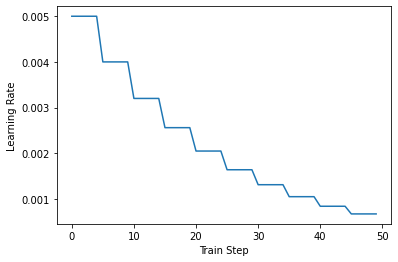

In [ ]:
#@title
#learning_rate_tot = []
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=10):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step ** 1.5)
    arg2 = step * ((self.warmup_steps+10) ** -1.3)
    lr = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    print(step)

    return lr

d_model = 500
learning_rate_custom_1 = CustomSchedule(d_model)
plt.plot(learning_rate(tf.range(50, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


learning_rate_custom_2 = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=5,
    decay_rate=0.80,
    staircase=True)
plt.plot(learning_rate(tf.range(50, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Adamax

## Architecture

In [ ]:
# Input Layer
X = Input(shape=(None, ), batch_size=batch_size)

# Embedding Layer
embedded = Embedding(vocab_size, embedding_size, 
                     batch_input_shape=(batch_size, None), 
                     embeddings_regularizer=tf.keras.regularizers.L2()
                     )(X)

# Dense layer
embedded = Dense(embedding_size, relu)(embedded)

# First LSTM
encoder_output, hidden_state, cell_state = LSTM(units=lstm_unit_1,
                                                         return_sequences=True,
                                                         return_state=True)(embedded)
# Dropout
encoder_output = Dropout(0.3)(encoder_output)
# Dense layer
encoder_output = Dense(embedding_size, activation='relu')(encoder_output)

# Concat of first LSTM hidden state
initial_state_double = [tf.concat([hidden_state, hidden_state], 1), tf.concat([hidden_state, hidden_state], 1)]

# Second LSTM
encoder_output, hidden_state, cell_state = LSTM(units=lstm_unit_2,
                                                         return_sequences=True,
                                                         return_state=True)(encoder_output, initial_state=initial_state_double)
# Dropout
encoder_output = Dropout(0.3)(encoder_output)
# Dense layer
encoder_output = Dense(hidden_size, activation='relu')(encoder_output)

# Prediction Layer
Y = Dense(units=vocab_size)(encoder_output)

# Compile model
model = Model(inputs=X, outputs=Y)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer='adam', metrics=[perplexity, sparse_categorical_crossentropy])
print(model.summary())

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(100, None)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (100, None, 200)     12800       input_9[0][0]                    
__________________________________________________________________________________________________
dense_32 (Dense)                (100, None, 200)     40200       embedding_8[0][0]                
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(100, None, 2048),  18423808    dense_32[0][0]                   
____________________________________________________________________________________________

## Training

In [ ]:
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        # returns a tensor with shape (batch_size, len_text)
        x_predicted = model(x)

        scce = tf.keras.losses.sparse_categorical_crossentropy(y, x_predicted, from_logits = True)
        # we cant return a tensor with that shape so we return a float that are summed
        custom = get_custom_loss(x_predicted, y)

        current_loss = tf.reduce_mean(scce + custom)

    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return current_loss, scce, custom


loss_history = []
custom_loss_history = []

for epoch in range(n_epochs):
    
    start = time.time()
    
    # Take subsets of train and target
    sample = np.random.randint(0, text_matrix.shape[0]-1, subset_size)
    sample_train = text_matrix[ sample , : ]
    sample_target = text_matrix[ sample+1 , : ]

    for iteration in range(sample_train.shape[0] // batch_size):
        take = iteration * batch_size
        x = sample_train[ take:take+batch_size , : ]
        y = sample_target[ take:take+batch_size , : ]

        current_loss, scce, custom = train_on_batch(x, y)
        loss_history.append(current_loss)
        custom_loss_history.append(custom)
    
    print("{}.  \t  Total-Loss: {%.2f}  \t  Custom-Loss: {%.2f}  \t Time: {} sec/epoch".format(
        epoch+1, current_loss.numpy(),custom, round(time.time()-start, 2)))


1.  	  Total-Loss: 4.010016441345215  	  Custom-Loss: 0.9637500047683716  	 Time: 293.47sec/epoch
2.  	  Total-Loss: 4.030500888824463  	  Custom-Loss: 0.9756249785423279  	 Time: 307.06sec/epoch
3.  	  Total-Loss: 3.182433605194092  	  Custom-Loss: 0.9568750262260437  	 Time: 312.95sec/epoch
4.  	  Total-Loss: 2.8650026321411133  	  Custom-Loss: 0.9837499856948853  	 Time: 313.92sec/epoch
5.  	  Total-Loss: 2.609344720840454  	  Custom-Loss: 0.9700000286102295  	 Time: 314.24sec/epoch
6.  	  Total-Loss: 2.517993688583374  	  Custom-Loss: 0.9725000262260437  	 Time: 314.17sec/epoch
7.  	  Total-Loss: 2.4020440578460693  	  Custom-Loss: 0.9524999856948853  	 Time: 313.59sec/epoch
8.  	  Total-Loss: 2.338041067123413  	  Custom-Loss: 0.965624988079071  	 Time: 314.41sec/epoch
9.  	  Total-Loss: 2.2583961486816406  	  Custom-Loss: 0.9237499833106995  	 Time: 314.22sec/epoch
10.  	  Total-Loss: 2.138793706893921  	  Custom-Loss: 0.9087499976158142  	 Time: 314.07sec/epoch
11.  	  Total-Los

In [ ]:
model.save("deep_comedy_custom_loss_01.h5")
from google.colab import files
files.download('deep_comedy_custom_loss_01.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Graphs

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(custom_loss_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

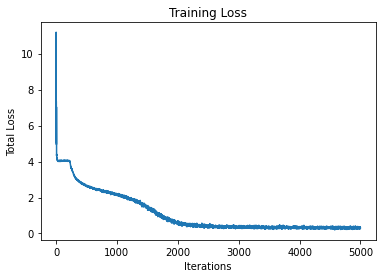

In [ ]:
plt.plot(loss_history)
plt.xlabel("Iterations")
plt.ylabel("Total Loss")
plt.title("Training Loss")
plt.show()

## Saved model
file name, len_matrix, batch_size, embedding_size, lstm_1_unit, lstm_2_unit, hidden_unit, epochs, learning_rate

model_custom_loss_01.h5: 150,100, 200, 2048,4096,300,50,0.001 BASE MODEL

model_custom_loss_02.h5: 150,**150**, 200, 2048,4096,300,50,0.001

model_custom_loss_03.h5: 150,100, 200, 2048,4096,300,50,**custom_exponential**

model_custom_loss_04.h5: 150,**150**, 200, 2048,4096,300,50,**custom_exponential**

model_custom_loss_05.h5: **200**,150, 200, 2048,4096,300,50,0.001

model_custom_loss_06.h5: **100**,150, 200, 2048,4096,300,50,0.001

# Text Generation

At this point, let's check how the model generates text. In order to do it, I must make some changes to my RNN architecture above.

First, I must change the fixed batch size. After training, I want to feed just one sentence into my Network to make it continue the character sequence. I will feed a string into the model, make it predict the next character, update the input sequence, and repeat the process until a long generated text is obtained. Because of this, the succession of input sequences is now different from training session, in which portions of text were sampled randomly. I now have to set `stateufl = True` in the `LSTM()` layer, so that each LSTM cell will keep in memory the internal state from the previous sequence. With this I hope the model will better remember sequential information while generating text.

I will instantiate a new `generator` RNN with these new features, and transfer the trained weights of my `RNN` into it.

In [20]:
# Input Layer
X = Input(shape=(None, ), batch_size=1)
embedded = Embedding(vocab_size, embedding_size)(X)
embedded = Dense(embedding_size, relu)(embedded)
encoder_output, hidden_state, cell_state = LSTM(units=lstm_unit_1,
                                                         return_sequences=True,
                                                         return_state=True,
                                              stateful=True)(embedded)
encoder_output = Dropout(0.3)(encoder_output)
encoder_output = Dense(embedding_size, activation='relu')(encoder_output)

initial_state_double = [tf.concat([hidden_state, hidden_state], 1), tf.concat([hidden_state, hidden_state], 1)]
encoder_output, hidden_state, cell_state = LSTM(units=lstm_unit_2,
                                                         return_sequences=True,
                                                         return_state=True,
                                                stateful=True)(encoder_output, initial_state=initial_state_double)
encoder_output = Dropout(0.3)(encoder_output)
encoder_output = Dense(hidden_size, activation='relu')(encoder_output)

Y = Dense(units=vocab_size)(encoder_output)

# Compile model
generator = Model(inputs=X, outputs=Y)
generator.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer='adam', metrics=[perplexity, sparse_categorical_crossentropy])
print(generator.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, None)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (1, None, 200)       12400       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (1, None, 200)       40200       embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     [(1, None, 2048), (1 18423808    dense[0][0]                      
______________________________________________________________________________________________

In [ ]:
# Import trained weights from RNN to generator
load_file = True
if load_file:
  generator.load_weights("deep_comedy_custom_loss_01.h5")
else:
  generator.set_weights(model.get_weights())

In [ ]:
def generate_text(start_string, model, num_generate = 1000, temperature = 1.0):
    
    # Vectorize input string
    input_eval = [char2idx[s] for s in start_string]  
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = [] # List to append predicted chars 
    
    idx2char = { v: k for k, v in char2idx.items() }  # invert char-index mapping
    
    model.reset_states()
    
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # sample next char based on distribution and temperature
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
    return (start_string + ''.join(text_generated))

In [ ]:
# Let's feed the first lines:
start_string = """
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.

"""

for t in [0.1, 0.2, 0.2, 0.5, 1.0]:
    print("####### TEXT GENERATION - temperature = {}\n".format(t))
    print(generate_text(start_string, generator, num_generate = 1000, temperature = t))
    print("\n\n\n")

In [ ]:
print("FINISCHED")

FINISCHED


In [ ]:
# Exam mode for 1 Canto so 33 terzine
start_inferno = """
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.

"""

start_purgatorio = """
Per correr miglior acque alza le vele
omai la navicella del mio ingegno,
che lascia dietro a se mar si crudele;

"""

start_paradiso = """
La gloria di colui che tutto move
per l'universo penetra, e risplende
in una parte più e meno altrove.

"""

print(generate_text(start_string = start_purgatorio, num_generate = 1000, temperature = 0.1))


Per correr miglior acque alza le vele
omai la navicella del mio ingegno,
che lascia dietro a se mar si crudele;

e canterò di quel secondo regno
dove l'umano spirito si purga
e di salire al ciel diventa degno. 

Ma qui la morta poesì resurga,
o sante Muse, poi che vostro sono;
e qui Caliopè alquanto surga, 

seguitando il mio canto con quel suono
di cui le Piche misere sentiro
lo colpo tal, che disperar perdono. 

Dolce color d'oriental zaffiro,
che s'accogliendo il carro e la vergogna
per la mia morte, e per la mesta salusfa
o da prova che riceve il sole e 'l verno, 

per la ragion che di', quinci si parte
verso settentrion, quanto li Ebrei
vedevan lui verso la calda parte. 

Ma se a te piace, volontier saprei
quanto avemo ad andar; ché 'l poggio sale
più che salir non posson li occhi miei". 

Ed elli a me: "Se tu segui tua stella,
non puoi fallire a glorioso porto,
se ben m'accorsi ne la vita bella; 

e s'io non fossi sì per tempo morto,
veggendo il cielo a te così benigno,
dato t'a

# NEW IDEAS

#### Training:
*   Cross validation
*   Insert Rhyme as feature to learn as haiku
*   Use syllable as input and not word
*   Different training on different dataset
* Use categorical_crossentropy instead of sparse_ but with one-hot encoded inputs
* Symbols for explicit start and end terzina
* training as classificator for structure: like "these two world are rhymes" or "this is a endecasillable and this not" or "this is a terzina and this not" then generation
* use dropout 
* use two lstm
* 

#### Presentation
* graphs over the vocabulary like distribution of used words




In [ ]:
RNN = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(batch_size, None)),
              
    Dense(embedding_size, activation = relu),
    
    LSTM(len_input, return_sequences = True),

    Dropout(0.3),
    
    Dense(hidden_size, activation = relu), 

    Dropout(0.3),
    
    Dense(vocab_size)
])

RNN.summary()

generator = Sequential([
    Embedding(vocab_size, embedding_size,batch_input_shape=(1, None)),

    Dense(embedding_size, activation = relu),
    
    LSTM(len_input, return_sequences = True, stateful=True),

    Dropout(0.3),
    
    Dense(hidden_size, activation = relu), 

    Dropout(0.3),
    
    Dense(vocab_size)


])

generator.summary()

In [ ]:
#@title
#@DEBUG CUSTOM LOSS

x = [[49, 46, 36, 44, 49, 32, 48, 36,  1, 45,  1, 35, 51, 36,  1, 45,  1, 50,
 48, 36,  1, 46, 36, 48,  1, 49, 36, 30,  5,  0, 44, 45, 44,  1, 42, 32,
  1, 37, 45, 48, 50, 51, 44, 32,  1, 35, 40,  1, 46, 48, 40, 43, 32,  1,
 52, 32, 34, 32, 44, 50, 36,  5,  0, 44, 45, 44,  1, 35, 36, 34, 40, 43,
 32, 49,  5,  1, 47, 51, 32, 36,  1, 49, 51, 44, 50,  1, 46, 32, 51, 46,
 36, 48, 51, 43,  1, 14, 36, 40,  5,  1,  0,  0, 32, 35, 35, 40, 43, 32,
 44, 35, 60,  5,  1, 43, 32,  1, 34, 45, 44, 50, 48, 45,  1, 32, 42,  1,
 43, 45, 44, 35, 45,  1, 36, 48, 48, 32, 44, 50, 36,  0, 42, 40, 34, 36,
 44, 55, 32,  1, 35, 40], 
 [42,  1, 34, 45, 44, 49, 40, 38, 42, 40, 45,  1, 44, 36, 42,  1, 47, 51,
 32, 42, 36,  1, 45, 38, 44, 36,  1, 32, 49, 46, 36, 50, 50, 45,  0, 34,
 48, 36, 32, 50, 45,  1, 58,  1, 52, 40, 44, 50, 45,  1, 46, 48, 40, 32,
  1, 34, 39, 36,  1, 52, 32, 35, 32,  1, 32, 42,  1, 37, 45, 44, 35, 45,
  5,  1,  0,  0, 46, 36, 48, 60,  1, 34, 39, 36,  1, 32, 44, 35, 32, 49,
 49, 36,  1, 52, 36, 48,  4,  1, 42, 45,  1, 49, 51, 45,  1, 35, 40, 42,
 36, 50, 50, 45,  0, 42, 32,  1, 49, 46, 45, 49, 32,  1, 35, 40,  1, 34,
 45, 42, 51, 40,  1, 34, 39,  4, 32, 35,  1, 32, 42, 50, 36,  1, 38, 48,
 40, 35, 32,  0, 35, 40,]]
y = [[46, 36, 44, 49, 32, 48, 36,  1, 45,  1, 35, 51, 36,  1, 45,  1, 50, 48,
 36,  1, 46, 36, 48,  1, 49, 36, 40,  5,  0, 44, 45, 44,  1, 42, 32,  1,
 37, 45, 48, 50, 51, 44, 32,  1, 35, 40,  1, 46, 48, 40, 43, 32,  1, 52,
 32, 34, 32, 44, 50, 36,  5,  0, 44, 45, 44,  1, 35, 36, 34, 40, 43, 32,
 49,  5,  1, 47, 51, 32, 36,  1, 49, 51, 44, 50,  1, 46, 32, 51, 46, 36,
 48, 51, 43,  1, 14, 36, 40,  5,  1,  0,  0, 32, 35, 35, 40, 43, 32, 44,
 35, 60,  5,  1, 43, 32,  1, 34, 45, 44, 50, 48, 45,  1, 32, 42,  1, 43,
 45, 44, 35, 45,  1, 36, 48, 48, 32, 44, 50, 36,  0, 42, 40, 34, 36, 44,
 55, 32,  1, 35, 40,  1], [ 1, 34, 45, 44, 49, 40, 38, 42, 40, 45,  1, 44, 36, 42,  1, 47, 51, 32,
 42, 36,  1, 45, 38, 44, 36,  1, 32, 49, 46, 36, 50, 50, 45,  0, 34, 48,
 36, 32, 50, 45,  1, 58,  1, 52, 40, 44, 50, 45,  1, 46, 48, 40, 32,  1,
 34, 39, 36,  1, 52, 32, 35, 32,  1, 32, 42,  1, 37, 45, 44, 35, 45,  5,
  1,  0,  0, 46, 36, 48, 60,  1, 34, 39, 36,  1, 32, 44, 35, 32, 49, 49,
 36,  1, 52, 36, 48,  4,  1, 42, 45,  1, 49, 51, 45,  1, 35, 40, 42, 36,
 50, 50, 45,  0, 42, 32,  1, 49, 46, 45, 49, 32,  1, 35, 40,  1, 34, 45,
 42, 51, 40,  1, 34, 39,  4, 32, 35,  1, 32, 42, 50, 36,  1, 38, 48, 40,
 35, 32,  0, 35, 40, 49,] ]

'''
EXPERIMENT
CUSTOM LOSS
'''
from functools import reduce


def divide_versi(y):
  doppiozero = False

  y_divided = [[]]
  for ly in y:
    ly = int(ly)

    # devo pulire la lista dai segni di punteggiatura, 
    # in chartoidx significa i numeri da 1 a 10 compresi.
    if ly in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:  # con i Tensor non funziona
    # if ly is 1 or ly is 2 or ly is 3 or ly is 4 or ly is 5 or ly is 6 or ly is 7 \
    #     or ly is 8 or ly is 9 or ly is 10:
        continue
    else:
      # se è zero vuol dire \n quindi aggiungo una nuova riga
      if ly is 0:
        if not doppiozero:
          y_divided.append([])
        doppiozero = True
        continue

      y_divided[-1].append(ly)
      doppiozero = False

  if y_divided is not []:
    if y[-1] != 0:
      # dato che l'ultima riga non finisce con 0 vuol dire che è incompleta e la rimuovo
      y_divided.pop()

  # i need to re check because maybe i pop the only one
  if len(y_divided) != 0:
    if len(y_divided[0]) < 3:
      # se la prima riga è minore di 4 non posso farci nulla quindi la elimino
      y_divided.pop(0)

  return y_divided

def rhymes_extractor(y_divided):
  # estraggo lo schema di rime da y
  rhymes = []
  for i in range(len(y_divided)):
    # con la fine del verso (ultime due lettere) controllo se le altre righe 
    # finiscono con le stesse lettere
    vy = y_divided[i]

    last_word_1 = vy[-2:]

    # ABA BCB CDC

    # devo controllare se la riga i fa rima con la riga i+2 
    if i+2 < len(y_divided):
      next_vy = y_divided[i+2]
      # print(vy[-2:])
      # print(next_vy[-2:])
      if last_word_1 == next_vy[-2:]:
        rhymes.append((i, i+2))
    
    if i+4 < len(y_divided):
      # print(vy[-2:])
      # print(next_vy[-2:])
      next_vy = y_divided[i+4]
      if last_word_1 == next_vy[-2:]:
        rhymes.append((i, i+4))

  # print(rhymes)
  return rhymes


def get_custom_loss(x_batch, y_batch):
  summed_custom_loss = 0
  # x_batch ha lo shape (200, 200) quindi ho 200 vettori con 200 lettere ognuno
  # le 200 lettere sono le feature

  # max numero di rime possibili (arbitrario)
  max_rhymes = 4

  print("Shape di x_batch e y_batch")
  print((len(x_batch), len(x_batch[0])))
  print((len(y_batch), len(y_batch[0])))

  x_bin_tot = np.ones(shape=(len(x_batch), max_rhymes), dtype='float32')
  y_bin_tot = np.ones(shape=(len(x_batch), max_rhymes), dtype='float32')

  # scorro i 200 vettori
  # for (x, y) in zip(x_batch, y_batch):  # Non funziona con i tensori
  for v in range(len(x_batch)):
    x = x_batch[v]
    y = y_batch[v]

    # given that the model returns a matrix with shape (150, 62) with the probability
    # for each of the 62 character i need to use a categorical to choose the best
    # then flatten the matrix into a list for evaluating
    predicted_text = list(tf.random.categorical(x, num_samples=1).numpy())
    x = np.concatenate(predicted_text).ravel().tolist()

    # dividio il vettore in versi utili
    x_divided = divide_versi(x)
    y_divided = divide_versi(y)

    print("Divisione in versi di x_batch e y_batch")
    print(x_divided)
    print(y_divided)

    # assicuro che il numero di versi siano uguali
    # !!! non posso perchè il generato può avere errori e quindi, per esempio,
    # avere più o meno versi
    # assert len(x_divided) == len(y_divided)

    # estraggo lo schema di rime
    x_rhymes = rhymes_extractor(x_divided)
    y_rhymes = rhymes_extractor(y_divided)

    print("Rime dei versi di x_batch e y_batch")
    print(x_rhymes)
    print(y_rhymes)

    # mi ritorna una lista con il numero delle righe che fanno rima
    # Esempio: [(1,3), (2,4)] significa che le righe 1 e 3 fanno rima e che le 
    # righe 2 e 4 pure 
    # TODO se avessimo due terzine intere si potrebbe valutare rime a 3 righe [aBaBcB]

    # creo un vettore di 1 per la y perchè le rime ci sono sempre
    y_bin = np.ones(max_rhymes, dtype='float32')
    # creo un vettore di 1 per le rime generate, metterò 0 se la rima 
    # NON è presente in dante, abbuono con uno 0.5 visto che c'è la rima almeno
    x_bin = np.ones(max_rhymes, dtype='float32')

    if x_rhymes == []:
      x_bin = np.zeros(max_rhymes, dtype='float32')

    # se la rima generata è nelle rime originali di Dante allora la segno come valida
    # tengo massimo max_ryhmes rime: posso perchè in 150-200 caratteri non ho più di 5-6 righe
    # quindi in Dante avrei 2 rime, eccedo di 2 per aiutare la rete a creare rime anche sbagliate
    for i in range(max_rhymes+1):
      if i < len(x_rhymes):
        if y_rhymes[i] not in x_rhymes:
          x_bin[i] = 0.
        if x_rhymes[i] not in y_rhymes:
          x_bin[i] = 0.5

    print("Vettore che rappresenta il confronto delle rime tra il generato e Dante dei versi di x_batch e y_batch \n y è sempre 1 mentre il generato ha 1 se la rima c'è in dante o 0.5 se non c'è ")
    print(x_bin)
    print(y_bin)
      
    # concateno i vettori con l'encoding delle rime
    x_bin_tot[v] = x_bin
    y_bin_tot[v] = y_bin

  print("Matrice dei vettori su cui eseguo la MSE: (x,y)")
  print(x_bin_tot)
  print(y_bin_tot)
  r = tf.keras.losses.mean_squared_error(y_bin_tot, x_bin_tot)

  print("Risultato della MSE:")
  print(r)

  print("Loss finale fatta con la media della MSE")
  print(np.mean(r))
  # MSE sui vettori
  return np.mean(r)



debug_loss = True
custom_loss = get_custom_loss(x,y)
print(custom_loss)

# NEW VERSION
# creo un vettore con le rime di y reale e di y generato
# Ex: in y reale se ho ABABC il vettore è [1,2,1,2,3] con o zero ad indicare nulla
# per y generato devo creare un vettore di lunghezza uguale per poi valutarlo con una sparse_crossentropy
# problema: non avrà mai le stesse righe

# extract matrix of index of where the zeros are
#tf.map_fn(fn=lambda t: t.map_fn(fn=lambda x: 1 if x == 0 else 0), elems=x_batch)
